# Assignment — Power Law

In [359]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zlib import adler32
import requests
import networkx as nx
from typing import List
from sklearn.linear_model import LinearRegression
from scipy.stats import kstest
from scipy.stats import powerlaw

The PDF of the Power law distribution is 

$$ p(x) = Cx^{-\alpha},$$ 

where $C$ is a normalization constant 

$$C = \frac{\alpha - 1}{x_{\text{min}}^{-\alpha + 1}}$$ 

and $\alpha>1$ is called an exponent of the distribution. 

In [2]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

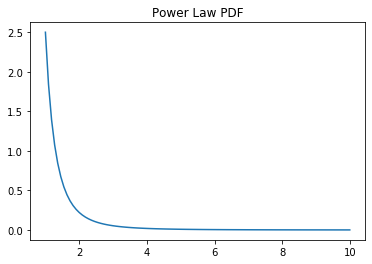

In [3]:
x_space = np.linspace(1, 10, 100)
plt.plot(x_space, power_law_pdf(x_space))
plt.title('Power Law PDF');

Let us generate observations from a Power Law RV.

### Task 1. Power law CDF (0.6 point)

The first step is to derive CDF of Powel law: $F(x) = P(X \leq x)$

$$F(x) = 1 - \int_{x}^\infty p(t) dt.$$

Take the integral, derive CDF analytically and write a function `power_law_cdf` with parameters `x`, `alpha` and `x_min`.

In [4]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return 1 + C * 1/(-alpha + 1) * x ** (-alpha + 1)

In [5]:
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9
assert adler32(str(power_law_cdf(2, 3, 1)).encode()) == 32571595

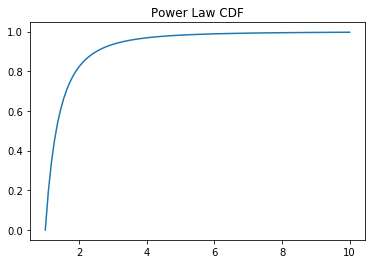

In [6]:
x_space = np.linspace(1, 10, 100)
plt.plot(x_space, power_law_cdf(x_space))
plt.title('Power Law CDF');

### Task 2. Power law PPF (0.6 point)

Let $X \sim \text{Power law}$. Next, define a random variable $R$, s.t. $R = F(X)$, so $R$ will be uniformly distributed on interval [0, 1] ([proof](https://en.wikipedia.org/wiki/Probability_integral_transform#Proof)). Good thing here is that we easily can generate uniformly distributed pseudorandom numbers and then transform them into Power Law. Let us find an expression for $x = F^{-1}(r)$, where $r$ is an observation from uniform distrubution on interval [0, 1]. 

Find an analytical form of $F^{-1}(r)$ and write a function `power_law_ppf` (percent point function, also known as a quantile) with parameters `r`, `alpha` and `x_min`. 

In [7]:
def power_law_ppf(r, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return ((r - 1) / (C * 1/(-alpha + 1))) ** (1 / (-alpha + 1))

In [8]:
assert round(power_law_ppf(0.5, 2, 1), 2) == 2
assert round(power_law_ppf(0.9, 2, 1), 2) == 10
assert adler32(str(round(power_law_ppf(0.96, 3, 1), 2)).encode()) == 19792020

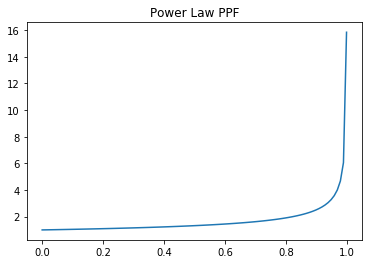

In [9]:
x_space = np.linspace(0, 0.999, 100)
plt.plot(x_space, power_law_ppf(x_space))
plt.title('Power Law PPF');

Finally, we can generate observation from Power law distribution as follows:
1. Generate observation from uniform distribution on interval [0, 1]
2. Calculate PPF value of given observation

In [10]:
def power_law_generate(n, alpha=3.5, x_min=1, random_seed=1):
    np.random.seed(random_seed)
    uni_sample = np.random.uniform(0, 0.999, n)
    return power_law_ppf(uni_sample, alpha, x_min)

Look at the histogram of the generated sample

In [11]:
alpha = 3.5
x_min = 1
x_train = power_law_generate(1000, alpha, x_min)
x_space = np.linspace(1, 15, 100)

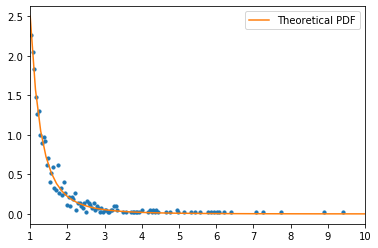

In [12]:
hist, bin_edges = np.histogram(x_train, bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=10)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), 
         label='Theoretical PDF', c='tab:orange')
plt.legend()
plt.xlim(1, 10)
plt.show()

And here is the same histogram in log-log scale

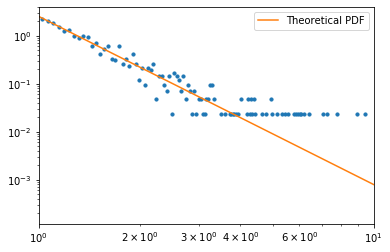

In [13]:
hist, bin_edges = np.histogram(x_train, bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), 
         label='Theoretical PDF', c='tab:orange')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 10)
plt.show()

### Task 3. Estimation of alpha with linear binning (0.6 point)

Given observations from the Power Law distribution, try to estimate $\alpha$. The easiest way is to draw an empirical PDF with linear binning in log-log scale and apply linear regression. By _linear binning_ we mean to keep a bin width is fixed.

Write a function `alpha_lin_bins` that takes a train set, number of linear bins and returns an estimated $\alpha$.

_Hints:_
* _Take log in both side of $p(x) = Cx^{-\alpha}$_
* _To calculate an empirical PDF, use `np.histogram(x_train, bins=bins, density=True)`_
* _To calculate pseudoinverse matrix, use `np.linalg.pinv`_
* _Also you can use fit-predict in `sklearn.linear.LinearRegression`_

In [17]:
def alpha_lin_bins(x_train, bins):
    histogram = np.histogram(x_train, bins)
    density = histogram[0][np.where(histogram[0] != 0)]
    density = np.log(density / len(x_train))
    bin_centres = np.log((histogram[1][1:] + histogram[1][:-1]) / 2)
    bin_centres = bin_centres[np.where(histogram[0] != 0)]
    bin_centres = bin_centres.reshape(-1, 1)
    regression = LinearRegression()
    regression.fit(bin_centres, density)
    
    return abs(regression.coef_[-1])

In [18]:
bins = 100
x_train = power_law_generate(1000, x_min=1, alpha=2)
assert np.abs(alpha_lin_bins(x_train, bins) - 2) < 0.7
x_train = power_law_generate(1000, x_min=1, alpha=3.5)
assert np.abs(alpha_lin_bins(x_train, bins) - 3.5) < 0.9
x_train = power_law_generate(1000, x_min=1, alpha=10)
assert np.abs(alpha_lin_bins(x_train, bins) - 10) < 2

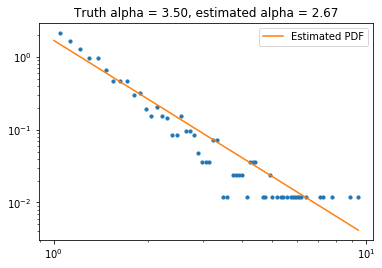

In [19]:
x_min = 1
alpha = 3.5
bins = 100

x_train = power_law_generate(1000, alpha, x_min)
hist, bin_edges = np.histogram(x_train, bins=bins, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)

hat_alpha = alpha_lin_bins(x_train, bins)
x_space = np.linspace(x_min, x_train.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, x_min), 
         label='Estimated PDF', c='tab:orange')
plt.legend()
plt.title('Truth alpha = {:.2f}, estimated alpha = {:.2f}'.format(alpha, hat_alpha))
plt.xscale('log')
plt.yscale('log')
plt.show()

### Task 4. Estimation of alpha with logarithmic binning (2 points)

As we see the estimation with linear binning is noticeably inaccurate. For logarithmic binning we let the bin sizes increase with the value, making sure that each bin has a comparable number of observations.

Write a function `alpha_log_bins` that takes a train set, number of log bins and returns an estimated $\alpha$.

*Hint: use `np.logspace(np.log10(x_min), np.log10(x_train.max()), bins)` to generate an increasing logarithmic sequence of bins*

In [78]:
def alpha_log_bins(x_train, bins):
    bins = np.logspace(np.log10(1), np.log10(x_train.max()), bins)
    histogram = np.histogram(x_train, bins = bins, density=True)
    density = np.log(histogram[0][np.where(histogram[0] != 0)])
    bin_centres = np.log((bins[1:] + bins[:-1]) / 2)
    bin_centres = bin_centres[np.where(histogram[0] != 0)]
    bin_centres = bin_centres.reshape(-1, 1)
    regression = LinearRegression()
    regression.fit(bin_centres, density)
    
    return abs(regression.coef_[-1])

In [79]:
x_train = power_law_generate(1000, x_min=1, alpha=2)
bins = 100
alpha_log_bins(x_train, bins)

1.834951589245696

In [80]:
bins = 100
x_train = power_law_generate(1000, x_min=1, alpha=2)
assert np.abs(alpha_log_bins(x_train, bins) - 2) < 0.2
x_train = power_law_generate(1000, x_min=1, alpha=3.5)
assert np.abs(alpha_log_bins(x_train, bins) - 3.5) < 0.5
x_train = power_law_generate(1000, x_min=1, alpha=10)
assert np.abs(alpha_log_bins(x_train, bins) - 10) < 1.5

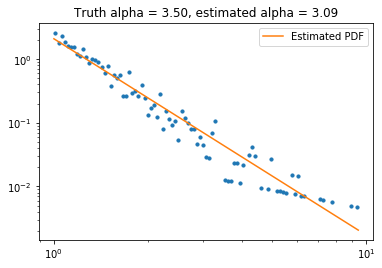

In [81]:
x_min = 1
alpha = 3.5
bins = 100

x_train = power_law_generate(1000, alpha, x_min)
binning = np.logspace(np.log10(x_min), np.log10(x_train.max()), bins)
hist, bin_edges = np.histogram(x_train, bins=binning, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)

hat_alpha = alpha_log_bins(x_train, bins)
x_space = np.linspace(x_min, x_train.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, x_min), 
         label='Estimated PDF', c='tab:orange')
plt.legend()
plt.title('Truth alpha = {:.2f}, estimated alpha = {:.2f}'.format(alpha, hat_alpha))
plt.xscale('log')
plt.yscale('log')
plt.show()

### Task 5. Generation graphs with a given degree distribution (0.6 point)

In this task we will generate different types of graph from its degree distributions.

__Graph A__ should be described with the density `[0, 2, 10]`.

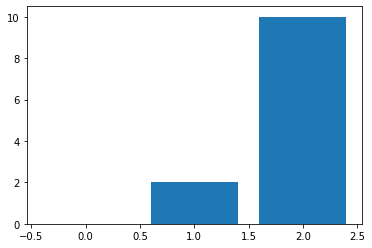

In [82]:
dens_a = [0, 2, 10]
plt.bar(range(len(dens_a)), dens_a);

In [83]:
def generate_graph_a() -> nx.Graph:
    return nx.path_graph(12)

In [84]:
assert nx.degree_histogram(generate_graph_a()) == dens_a

__Graph B__

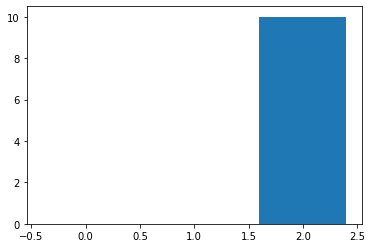

In [85]:
dens_b = [0, 0, 10]
plt.bar(range(len(dens_b)), dens_b);

In [86]:
def generate_graph_b() -> nx.Graph:
    return nx.cycle_graph(10)

In [87]:
assert nx.degree_histogram(generate_graph_b()) == dens_b

__Graph C__

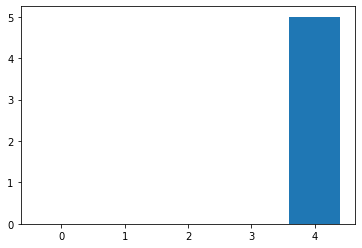

In [88]:
dens_c = [0, 0, 0, 0, 5]
plt.bar(range(len(dens_c)), dens_c);

In [91]:
def generate_graph_c() -> nx.Graph:
    return nx.complete_graph(5)

In [92]:
assert nx.degree_histogram(generate_graph_c()) == dens_c

__Graph D__

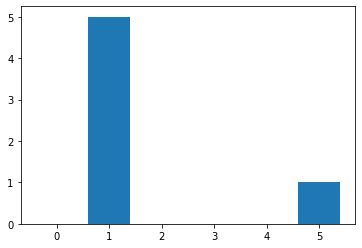

In [93]:
dens_d = [0, 5, 0, 0, 0, 1]
plt.bar(range(len(dens_d)), dens_d);

In [98]:
def generate_graph_d() -> nx.Graph:
    return nx.star_graph(5)

In [99]:
assert nx.degree_histogram(generate_graph_d()) == dens_d

### Task 6. Reading a degree distribution from a file (2 points)

In this task we will estimate CDF of degree distribution of a given graph. Firstly, let us download the Game of Thrones relationships dataset and create a graph.

In [123]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/network-science-course/network-science-course/main/datasets/game_of_thrones_relationships.csv")


In [124]:
raw_data.head()

,character1,character2,relationship,type
0,/wiki/Nymeria_Sand,/wiki/Oberyn_Martell,father,biological
1,/wiki/Bran_Stark,/wiki/Eddard_Stark,father,biological
2,/wiki/Bran_Stark,/wiki/Catelyn_Stark,mother,NaN
3,/wiki/Lothar_Frey,/wiki/Walder_Frey,father,biological
4,/wiki/Robb_Stark,/wiki/Eddard_Stark,father,biological


In [125]:
g = nx.from_pandas_edgelist(raw_data, source="character1", target="character2")

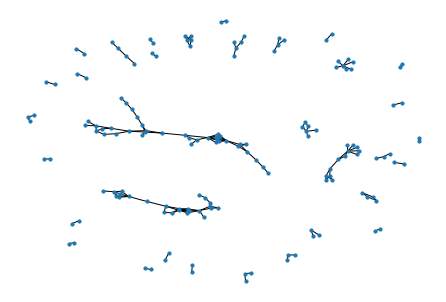

In [126]:
nx.draw(g, node_size=10)

In the social network analysis, we will often consider the largest connected component only. Before estimation of CDF, we need to remove all connected components except of the largest one.

_Hint: use `nx.connected_components` to get a list of nodes for each connected component._

In [142]:
def select_gygantic_component(g: nx.Graph) -> nx.Graph:
    components = nx.connected_components(g)
    max_length = 0
    gygantic_component = None
    for component in components:
        if len(component)>max_length:
            gygantic_component = component
            max_length = len(component)
            
    g1 = nx.Graph()
    g1.add_nodes_from(gygantic_component)
    g1.add_edges_from([edge for edge in g.edges if ((edge[0] and edge[1]) in g1.nodes)])
    return g1

In [144]:
gg = select_gygantic_component(g)
assert gg.number_of_edges() == 49
assert gg.number_of_nodes() == 37

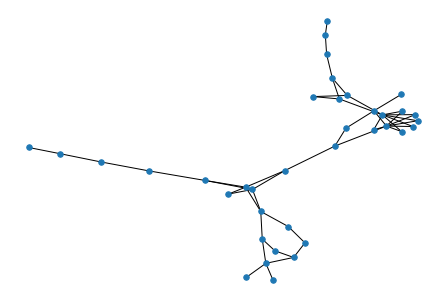

In [145]:
nx.draw(gg, node_size=30)

Now we can calculate an empirical CDF for a given graph. Recall a formal definition of CDF

$$F_X(x) = P(X \leq x)$$

And in empirical CDF, we estimate probability by share of nodes.

Write a method `empirical_cdf` that takes a graph and returns a np.array of probabilities. The first element is related to the node degree 0, the second — the node degree 1 and so on. The method should be able to group degrees occurence into equaly distributed bins. 

_Hint: use `nx.degee_histogram` to return a degree histogram — a list of numbers of nodes for each degree._

In [146]:
nx.degree_histogram(g)

[0, 75, 46, 24, 6, 4, 2, 1, 2]

In [159]:
def empirical_cdf(g: nx.Graph) -> List[float]:
    degrees = nx.degree_histogram(g)
    sum_degree = sum(degrees)
    probs = [0]
    for degree in degrees:
        probs.append(probs[-1]+degree)
    probs = np.array(probs)/sum_degree
    return probs

In [161]:
ecdf = empirical_cdf(gg)
assert ecdf[0] == 0
assert ecdf[-1] == 1
assert np.all(ecdf[:-1] <= ecdf[1:])
assert adler32(str(empirical_cdf(gg).round(4).sum()).encode()) == 70123823

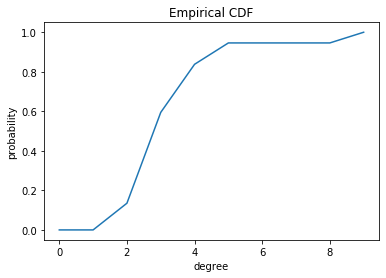

In [162]:
plt.plot(ecdf)
plt.xlabel('degree')
plt.ylabel('probability')
plt.title('Empirical CDF')
plt.show()

### Task 7. MLE of alpha in Power Law (3 points)

Let us estimate $\alpha$ and $x_\min$ of a real social network using maximum likelihood. Here is a real degree distribution of the network of emails between members of the research institution with 1005 nodes.

In [285]:
url = 'https://raw.githubusercontent.com/network-science-course/network-science-course/main/datasets/email_degree_sequence.txt'
open('email_degree_sequence.txt', 'wb').write(requests.get(url).content);


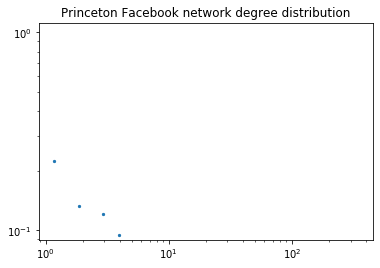

In [286]:
degree_sequence = np.loadtxt('email_degree_sequence.txt')
hist, bin_edges = np.histogram(degree_sequence, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('Princeton Facebook network degree distribution')
plt.xscale('log')
plt.yscale('log')

The MLE consists of:
1. Fix $x_\min$ as a minimal node degree (drop node degrees that less than $x_\min$)
2. Calculate $\alpha$ via maximum likelihood estimation using fixed $x_\min$
$$\alpha = 1 + n \left[\sum_i \log \frac{x_i}{x_\min} \right]^{-1}$$
3. Calculate Kolmogorov-Smirnov test
4. Fix $x_\min$ as the next node degree
5. Repeat 2-4 by scanning all possible $x_\min$ and find the best $\alpha$ and $x_\min$ with respect to Kolmogorov-Smirnov test

Write a function `ml_power_law_params` that takes a node degree sequence `degree_sequence` and returns a tuple of two values: the best $\alpha$ and $x_\min$.

_Hints:_
* _To calculate Kolmogorov-Smirnov distance use `scipy.stats.kstest` with a parameter `cdf=power_law_cdf`_

In [287]:
alpha, x_min = 7, 1
degree_sequence1 = power_law_generate(1000, alpha, x_min)
max(degree_sequence1)

2.5456625588552986

In [348]:
def mle_power_law_params(degree_sequence):
    best_x_min = 0
    best_alpha = 0
    ks_0 = 100000
    for x_min in range(int(min(degree_sequence)),int(max(degree_sequence))):
        
        new_deg_seq = [degree for degree in degree_sequence if degree >= x_min]
        n = len(new_deg_seq)
        xi_xmin = np.array([x_i/x_min for x_i in new_deg_seq])
        alpha = 1 + n*(np.sum(np.log(xi_xmin))**(-1))

        ks = kstest(new_deg_seq, cdf=power_law_cdf, args = (alpha, x_min))
        if ks[0]<ks_0:
            best_x_min = x_min
            best_alpha = alpha
            ks_0 = ks[0]
    return (best_alpha, best_x_min)

In [349]:
alpha, x_min = 3.5, 3
hat_alpha, hat_x_min = mle_power_law_params(power_law_generate(1000, alpha, x_min))
assert np.abs(hat_alpha - alpha) < 0.05
assert np.abs(hat_x_min - x_min) < 0.001

alpha, x_min = 7, 1
hat_alpha, hat_x_min = mle_power_law_params(power_law_generate(1000, alpha, x_min))
assert np.abs(hat_alpha - alpha) < 0.1
assert np.abs(hat_x_min - x_min) < 0.0001

hat_alpha, hat_x_min = mle_power_law_params(degree_sequence)
assert np.abs(hat_alpha - 2.9) < 0.1
assert np.abs(hat_x_min - 42) < 1

C:\Users\irisc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\irisc\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\irisc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\irisc\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


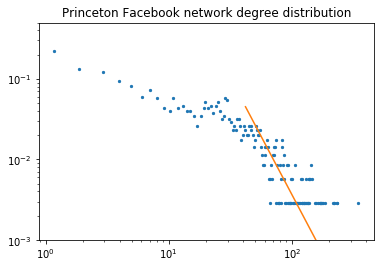

In [350]:
hist, bin_edges = np.histogram(degree_sequence, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('Princeton Facebook network degree distribution')

hat_alpha, hat_x_min = mle_power_law_params(degree_sequence)
x_space = np.linspace(hat_x_min, degree_sequence.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), 
         label='Estimated PDF', c='tab:orange')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.001, 0.5);

### Task 8. QQ plot (0.6 point)

It might be useful to draw a quantile-quantile plot (QQ plot) to compare empirical and theoretical distributions by the eye. Your task here is to generate Power Law observations by given parameters and compare theoretical and empirical quantiles.

Write a function `qqplot_data` that takes $\alpha$, $x_\min$, number of observations $n$ that will be generated and returns a tuple with two np.arrays: theoretical quantiles and empirical quantiles. Let quantiles be calculated for probabilities 0, 0.01, 0.02, ..., 0.99.

_Hint: to calculate an empirical quantile, use `np.quantile`_

In [391]:
def qqplot_data(alpha, x_min, n):
    observations = power_law_generate(n, alpha, x_min)
    quantiles = np.arange(0,1,0.01)
    empirical = np.quantile(power_law_generate(n, alpha, x_min), quantiles)
    theoretical = []
    for quantile in quantiles:
        theoretical.append(power_law_ppf(quantile,alpha,x_min))
    return (theoretical, empirical)

In [393]:
x_min = 1
alpha = 3.5

theor100, empir100 = qqplot_data(alpha, x_min, 100)
theor200, empir200 = qqplot_data(alpha, x_min, 200)
theor1000, empir1000 = qqplot_data(alpha, x_min, 1000)
assert np.linalg.norm(theor1000 - empir1000) < np.linalg.norm(theor200 - empir200)
assert np.linalg.norm(theor200 - empir200) < np.linalg.norm(theor100 - empir100)

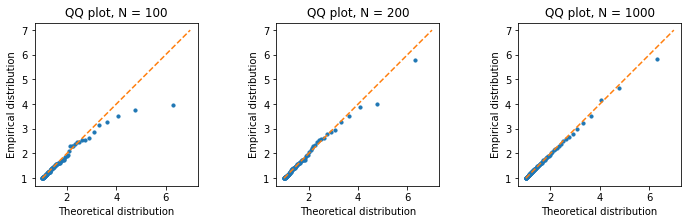

In [394]:
plt.figure(figsize=(12, 3))

plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1)
plt.scatter(theor100, empir100, s=10)
plt.plot([1, 7], [1, 7], '--', c='tab:orange')
plt.title('QQ plot, N = 100')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')
plt.axis('square')

plt.subplot(1, 3, 2)
plt.scatter(theor200, empir200, s=10)
plt.plot([1, 7], [1, 7], '--', c='tab:orange')
plt.title('QQ plot, N = 200')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')
plt.axis('square')

plt.subplot(1, 3, 3)
plt.scatter(theor1000, empir1000, s=10)
plt.plot([1, 7], [1, 7], '--', c='tab:orange')
plt.title('QQ plot, N = 1000')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')
plt.axis('square');